In [60]:
import pandas as pd
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set() # setting seaborn default for plots
import matplotlib.font_manager as fm
import copy
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
import numpy as np


from scipy import stats  # Box-Cox 검정
import statsmodels.api as sm  # qqplot
from statsmodels.tsa.stattools import adfuller    # adfuller : ADF그래프 그려주는 함수
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.stats.diagnostic import acorr_ljungbox # Ljung-Box 검정

import warnings
warnings.filterwarnings("ignore")

import itertools
import copy
from datetime import datetime,timedelta

In [61]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

In [62]:
plt.rc('font', family='NanumBarunGothic') 

In [63]:
#from google.colab import drive
#drive.mount('/content/drive')

In [64]:
# pip install -U pykrx  # KRX데이터를 크롤링하기 위한 라이브러리설치

In [65]:
from pykrx import stock

today=(datetime.today()-timedelta(10)).strftime("%Y%m%d")                      # 현재날짜
year1=(datetime.today()-timedelta(365)).strftime('%Y%m%d')     # 현재날짜로부터 1년전 날짜

df = stock.get_market_ohlcv_by_date(year1,today, "122870") # DataFrame, (시작날짜,종료날짜,종목번호)
df

와이지엔터테인먼트,시가,고가,저가,종가,거래량
날짜,,,,,
2019-10-21,24850,25450,24400,24900,243871
2019-10-22,25100,26550,24850,26400,513743
2019-10-23,26700,26800,25850,26350,326506
2019-10-24,26450,26750,25800,26400,203440
2019-10-25,26450,26550,25550,25850,188961
...,...,...,...,...,...
2020-09-29,57700,58000,54900,58000,758762
2020-10-05,57100,57400,51800,52500,1428801
2020-10-06,52000,53200,50200,51500,633818


In [66]:
# train,test 데이터 나누기

print('df.shape : ',df.shape)

# 조정가능한 값 (validation_size , test_size)
validation_size=40
test_size=10

train=df[:len(df)-validation_size]
validation=df[len(df)-validation_size:len(df)-test_size]
test=df[len(df)-test_size:]

print('train.shape : ',train.shape)
print('validation.shape : ',validation.shape)
print('test.shape : ',test.shape)

df.shape :  (241, 5)
train.shape :  (201, 5)
validation.shape :  (30, 5)
test.shape :  (10, 5)


In [67]:
# 전체적인 주가 데이터 살펴보기
df.describe()

와이지엔터테인먼트,시가,고가,저가,종가,거래량
count,241.000000,241.000000,241.000000,241.000000,2.410000e+02
mean,33774.066390,34665.767635,32914.937759,33834.647303,4.462416e+05
std,9637.196907,9875.751044,9296.400787,9616.124305,5.607677e+05
min,19650.000000,20100.000000,18950.000000,19450.000000,5.555200e+04
25%,26300.000000,26800.000000,25850.000000,26350.000000,2.070710e+05
50%,30750.000000,31550.000000,30000.000000,30750.000000,3.054400e+05
75%,38500.000000,39400.000000,37550.000000,38600.000000,4.911200e+05
max,59300.000000,60500.000000,57500.000000,58700.000000,5.841435e+06


In [68]:
train_data=pd.concat([train,validation],axis=0)
train_data

와이지엔터테인먼트,시가,고가,저가,종가,거래량
날짜,,,,,
2019-10-21,24850,25450,24400,24900,243871
2019-10-22,25100,26550,24850,26400,513743
2019-10-23,26700,26800,25850,26350,326506
2019-10-24,26450,26750,25800,26400,203440
2019-10-25,26450,26550,25550,25850,188961
...,...,...,...,...,...
2020-09-15,57800,58400,57000,58000,270909
2020-09-16,58000,58800,57300,58300,290431
2020-09-17,58300,58300,55800,56300,427639


In [69]:
test_data=pd.concat([train_data,test],axis=0)
test_data

와이지엔터테인먼트,시가,고가,저가,종가,거래량
날짜,,,,,
2019-10-21,24850,25450,24400,24900,243871
2019-10-22,25100,26550,24850,26400,513743
2019-10-23,26700,26800,25850,26350,326506
2019-10-24,26450,26750,25800,26400,203440
2019-10-25,26450,26550,25550,25850,188961
...,...,...,...,...,...
2020-09-29,57700,58000,54900,58000,758762
2020-10-05,57100,57400,51800,52500,1428801
2020-10-06,52000,53200,50200,51500,633818


In [70]:
# Prophet모델에 input되기 위해서는 ['ds','y']로 column형식을 맞춰야 함
train_data=pd.DataFrame({'ds':train_data.index,'y':train_data['종가']})
train_data=train_data.reset_index(drop=True)
train_data

,ds,y
0,2019-10-21,24900
1,2019-10-22,26400
2,2019-10-23,26350
3,2019-10-24,26400
4,2019-10-25,25850
...,...,...
226,2020-09-15,58000
227,2020-09-16,58300
228,2020-09-17,56300
229,2020-09-18,58000


In [71]:
train_data

,ds,y
0,2019-10-21,24900
1,2019-10-22,26400
2,2019-10-23,26350
3,2019-10-24,26400
4,2019-10-25,25850
...,...,...
226,2020-09-15,58000
227,2020-09-16,58300
228,2020-09-17,56300
229,2020-09-18,58000


In [72]:
cp=['2019-10-23', '2019-11-04', '2019-11-13', '2019-11-22', '2019-12-04', '2019-12-13', '2019-12-26', '2020-01-08', '2020-01-17', '2020-01-31', '2020-02-11', '2020-02-20', '2020-03-03', '2020-03-12', '2020-03-23', '2020-04-02', '2020-04-13', '2020-04-23', '2020-05-08', '2020-05-19', '2020-05-29', '2020-06-09', '2020-06-18', '2020-06-30', '2020-07-09']
cp2=[]

cp3=['2020-08-11',
 '2020-08-12',
 '2020-08-13',
 '2020-08-18',
 '2020-08-19',
 '2020-08-20',
 '2020-08-26',
 '2020-08-28',
 '2020-08-31',
 '2020-09-02',
 '2020-09-03',
 '2020-09-07',
 '2020-09-08']

cp3=cp+cp2
cp3

['2019-10-23',
 '2019-11-04',
 '2019-11-13',
 '2019-11-22',
 '2019-12-04',
 '2019-12-13',
 '2019-12-26',
 '2020-01-08',
 '2020-01-17',
 '2020-01-31',
 '2020-02-11',
 '2020-02-20',
 '2020-03-03',
 '2020-03-12',
 '2020-03-23',
 '2020-04-02',
 '2020-04-13',
 '2020-04-23',
 '2020-05-08',
 '2020-05-19',
 '2020-05-29',
 '2020-06-09',
 '2020-06-18',
 '2020-06-30',
 '2020-07-09']

In [73]:
#!pip install workalendar

In [74]:
from fbprophet import Prophet
from workalendar.asia import SouthKorea

m = Prophet(yearly_seasonality=True,changepoints=cp3)
m.fit(train_data)

kor_holidays = pd.concat([pd.Series(np.array(SouthKorea().holidays(2019))[:, 0]), pd.Series(np.array(SouthKorea().holidays(2020))[:, 0])]).reset_index(drop=True)
future = m.make_future_dataframe(periods=20)

future = future[future.ds.dt.weekday != 5]
future = future[future.ds.dt.weekday != 6]
for kor_holiday in kor_holidays:
    future = future[future.ds != kor_holiday]
    
future.tail()
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [75]:
forecast[ [ 'ds', 'yhat', 'yhat_lower', 'yhat_upper' ] ].tail()

,ds,yhat,yhat_lower,yhat_upper
240,2020-10-05,27718.014132,26344.273053,29027.859219
241,2020-10-06,25567.004581,24256.962431,26872.098179
242,2020-10-07,23576.742324,22234.931811,24926.042542
243,2020-10-08,21360.414288,20056.121080,22676.829518
244,2020-10-09,19106.509968,17678.279781,20392.297261


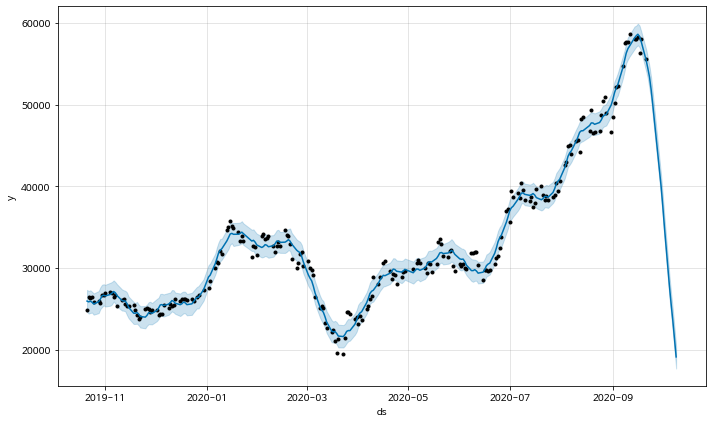

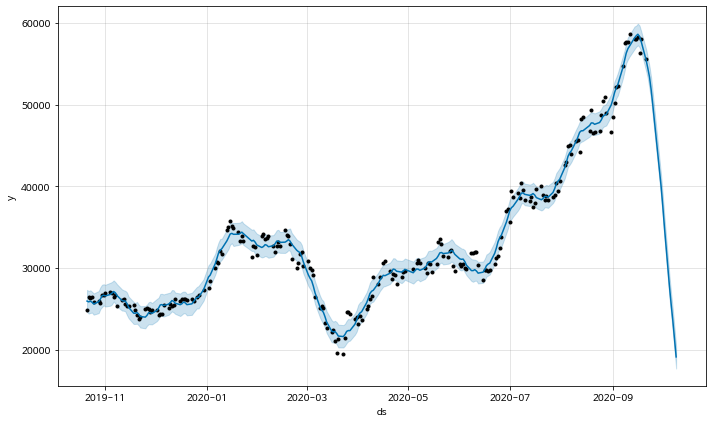

In [76]:
m.plot(forecast)

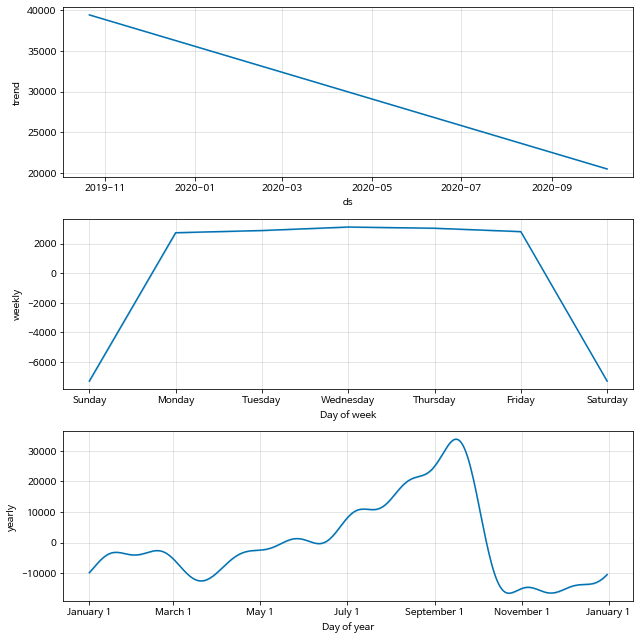

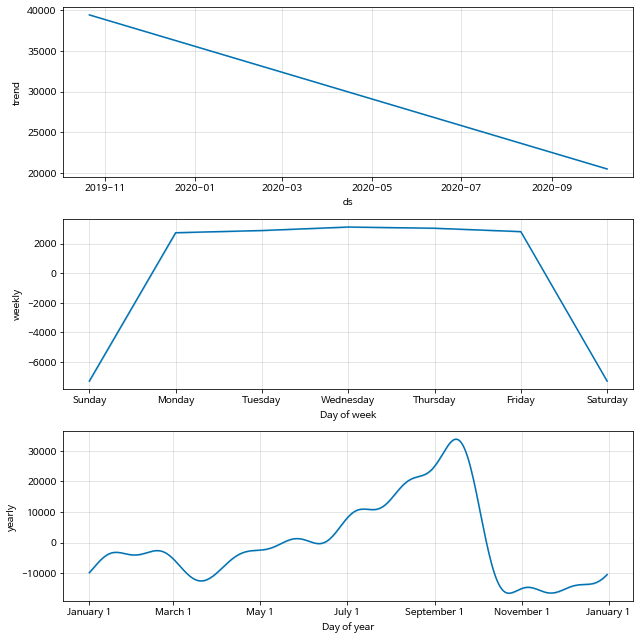

In [77]:
m.plot_components( forecast)

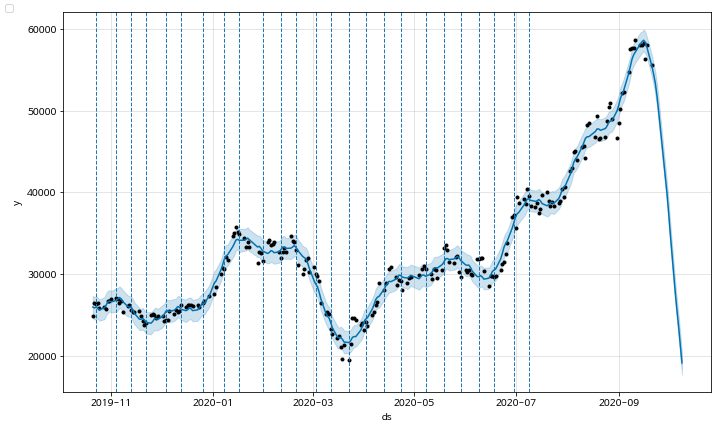

In [78]:
figure = m.plot(forecast)
for changepoint in m.changepoints:
    plt.axvline(changepoint,ls='--', lw=1)
figure.legend(loc=2)


In [84]:
import pickle
path='C:/Users/Kim SeoJeong/Turn_Around_PJ/Project_TurnAround/Meeting Materials/week10(10.13)'  # path를 바꿔주세요
pkl_path = path+"/Prophet.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(m, f)

# read the Prophet model object
with open(pkl_path, 'rb') as f:
     m = pickle.load(f)

# save the dataframe
#forecast.to_pickle(path+"/forecast.pkl")
#print("*** Data Saved ***")
# fcast = pd.read_pickle("path/to/data/forecast.pkl")

*** Data Saved ***


In [49]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-10-21,39447.902554,24595.595521,27166.883168,39447.902554,39447.902554,-13501.471047,-13501.471047,-13501.471047,2739.184675,2739.184675,2739.184675,-16240.655722,-16240.655722,-16240.655722,0.0,0.0,0.0,25946.431507
1,2019-10-22,39394.347971,24454.635123,27117.446656,39394.347971,39394.347971,-13547.260718,-13547.260718,-13547.260718,2888.070990,2888.070990,2888.070990,-16435.331708,-16435.331708,-16435.331708,0.0,0.0,0.0,25847.087253
2,2019-10-23,39340.793389,24644.131653,27283.464392,39340.793389,39340.793389,-13402.012067,-13402.012067,-13402.012067,3124.597899,3124.597899,3124.597899,-16526.609966,-16526.609966,-16526.609966,0.0,0.0,0.0,25938.781322
3,2019-10-24,39287.238807,24484.758650,27228.035485,39287.238807,39287.238807,-13486.262721,-13486.262721,-13486.262721,3042.636560,3042.636560,3042.636560,-16528.899281,-16528.899281,-16528.899281,0.0,0.0,0.0,25800.976086
4,2019-10-25,39233.684224,24306.931479,26929.461849,39233.684224,39233.684224,-13643.848737,-13643.848737,-13643.848737,2813.295810,2813.295810,2813.295810,-16457.144547,-16457.144547,-16457.144547,0.0,0.0,0.0,25589.835487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,2020-10-05,20703.795550,26382.809646,29025.096880,20703.795510,20703.795584,7014.218582,7014.218582,7014.218582,2739.184675,2739.184675,2739.184675,4275.033907,4275.033907,4275.033907,0.0,0.0,0.0,27718.014132
241,2020-10-06,20650.240956,24263.111471,26906.006885,20650.240910,20650.240995,4916.763625,4916.763625,4916.763625,2888.070990,2888.070990,2888.070990,2028.692634,2028.692634,2028.692634,0.0,0.0,0.0,25567.004581
242,2020-10-07,20596.686362,22189.763524,24827.702963,20596.686310,20596.686407,2980.055962,2980.055962,2980.055962,3124.597899,3124.597899,3124.597899,-144.541937,-144.541937,-144.541937,0.0,0.0,0.0,23576.742324
243,2020-10-08,20543.131768,19937.777601,22742.270014,20543.131711,20543.131819,817.282520,817.282520,817.282520,3042.636560,3042.636560,3042.636560,-2225.354040,-2225.354040,-2225.354040,0.0,0.0,0.0,21360.414288


In [50]:
forecast.index=forecast['ds']

<function matplotlib.pyplot.show(*args, **kw)>

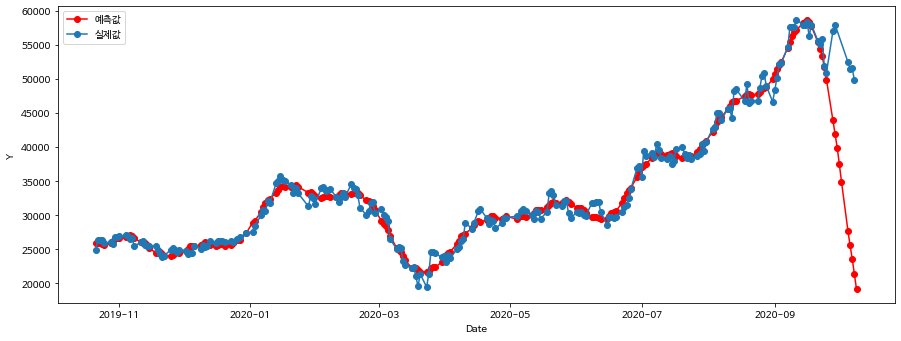

In [51]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(211)
ax1.plot(forecast['yhat'],color='red',marker='o',label='예측값')
ax1.plot(df['종가'],marker='o',label='실제값')
ax1.set_xlabel('Date')
ax1.set_ylabel('Y')
ax1.legend(loc='best')
plt.show

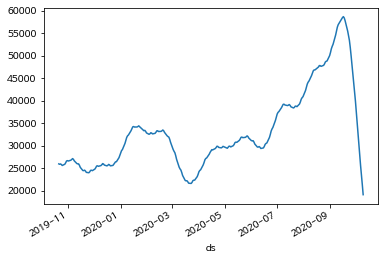

In [52]:
# forecast에서 test값의 인덱스만큼을 색을 다르게 그래프로 표현해서 보여주기 + changing point그래프 만들기   
forecast['yhat'].plot()

In [53]:
pip install plotly==4.0.0

Note: you may need to restart the kernel to use updated packages.


'C:\Users\Kim'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [54]:
'''
from fbprophet.plot import plot_plotly
from  plotly.offline import iplot, init_notebook_mode, plot
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode()
fig = plot_plotly(m, forecast)
py.iplot(fig)
'''

'\nfrom fbprophet.plot import plot_plotly\nfrom  plotly.offline import iplot, init_notebook_mode, plot\nimport plotly.offline as py\nimport plotly.graph_objs as go\n\npy.init_notebook_mode()\nfig = plot_plotly(m, forecast)\npy.iplot(fig)\n'

In [55]:
# 예측한 값만 그래프로 나타내서 비교하기
pred=forecast.tail(20)
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,
2020-09-14,2020-09-14,21828.442023,56831.812720,59564.020939,21828.442023,21828.442023,36359.575478,36359.575478,36359.575478,2739.184675,2739.184675,2739.184675,33620.390803,33620.390803,33620.390803,0.0,0.0,0.0,58188.017501
2020-09-15,2020-09-15,21774.887429,57112.549206,59773.105356,21774.887429,21774.887429,36670.483501,36670.483501,36670.483501,2888.070990,2888.070990,2888.070990,33782.412511,33782.412511,33782.412511,0.0,0.0,0.0,58445.370930
2020-09-16,2020-09-16,21721.332835,57257.355890,59887.202292,21721.332835,21721.332835,36918.438278,36918.438278,36918.438278,3124.597899,3124.597899,3124.597899,33793.840379,33793.840379,33793.840379,0.0,0.0,0.0,58639.771113
2020-09-17,2020-09-17,21667.778241,57014.730666,59676.408258,21667.778241,21667.778241,36684.788613,36684.788613,36684.788613,3042.636560,3042.636560,3042.636560,33642.152053,33642.152053,33642.152053,0.0,0.0,0.0,58352.566855
2020-09-18,2020-09-18,21614.223647,56392.611268,59215.952794,21614.223647,21614.223647,36130.289513,36130.289513,36130.289513,2813.295810,2813.295810,2813.295810,33316.993703,33316.993703,33316.993703,0.0,0.0,0.0,57744.513160
2020-09-21,2020-09-21,21453.559865,54092.091304,56785.285215,21453.559865,21453.559865,33974.289676,33974.289676,33974.289676,2739.184675,2739.184675,2739.184675,31235.105001,31235.105001,31235.105001,0.0,0.0,0.0,55427.849541
2020-09-22,2020-09-22,21400.005272,53136.601540,55710.137454,21400.005272,21400.005272,33052.515066,33052.515066,33052.515066,2888.070990,2888.070990,2888.070990,30164.444076,30164.444076,30164.444076,0.0,0.0,0.0,54452.520337
2020-09-23,2020-09-23,21346.450678,52019.368744,54720.940424,21346.450678,21346.450678,32033.461616,32033.461616,32033.461616,3124.597899,3124.597899,3124.597899,28908.863717,28908.863717,28908.863717,0.0,0.0,0.0,53379.912294
2020-09-24,2020-09-24,21292.896084,50526.668306,53171.120083,21292.896083,21292.896084,30517.544846,30517.544846,30517.544846,3042.636560,3042.636560,3042.636560,27474.908285,27474.908285,27474.908285,0.0,0.0,0.0,51810.440929


In [56]:
y=test_data.tail(20)
y

와이지엔터테인먼트,시가,고가,저가,종가,거래량
날짜,,,,,
2020-09-08,54700,58500,54200,57600,896783
2020-09-09,57700,60500,56200,57700,821117
2020-09-10,58700,59000,56700,57700,470213
2020-09-11,57400,60500,56900,58700,456164
2020-09-14,59300,59300,57500,58000,329573
2020-09-15,57800,58400,57000,58000,270909
2020-09-16,58000,58800,57300,58300,290431
2020-09-17,58300,58300,55800,56300,427639
2020-09-18,56900,58000,55600,58000,288517


In [57]:
pred.index=y.index

<function matplotlib.pyplot.show(*args, **kw)>

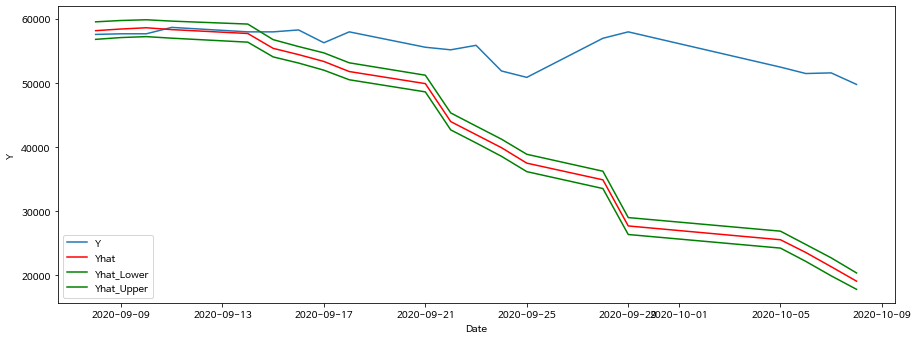

In [58]:
plt.rc('font', family='NanumBarunGothic') 

fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(211)
ax1.plot(y['종가'],label='Y')
ax1.plot(pred['yhat'],color='red',label='Yhat')
ax1.plot(pred['yhat_lower'],color='green',label='Yhat_Lower')
ax1.plot(pred['yhat_upper'],color='green',label='Yhat_Upper')
ax1.set_xlabel('Date')
ax1.set_ylabel('Y')
ax1.legend(loc='best')
plt.show

